In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import anndata as ad
import scanpy as sc

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from umap import UMAP

from scroutines import powerplots

import importlib
importlib.reload(powerplots)
from scroutines import basicu
from scroutines.miscu import is_in_polygon

import utils_merfish # merfish_utils import 

In [2]:
np.random.seed(0)

In [3]:
# functions (the teacher wrote for you to use later)
def rot2d(x, y, theta, unit='degree'):
    """ rotate data points defined by `x` and `y` by `theta` degree
    """
    a = np.vstack([x,y]).T
    if unit == 'degree':
        theta = theta*np.pi/180 # convert to radian

    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    ar = a.dot(R.T)
    return ar[:,0], ar[:,1]

def st_scatter(x, y, gexp=None, vmax_p=98, unit_norm=False, 
               title='', s=1, cbar_label='', output='', cmap='rocket_r', axis_off=True, 
               vmin=None, **cbar_kwargs):
    """customized scatter plot -- yesterday's progress
    """
    from mpl_toolkits.axes_grid1 import make_axes_locatable
  
    fig, ax = plt.subplots(figsize=(10,8))
    if gexp is not None:
        vmax = np.percentile(gexp, vmax_p)
        if unit_norm:
            rgexp = gexp/vmax
            g = ax.scatter(x, y, c=rgexp, s=s, edgecolor='none', vmin=vmin, vmax=1, cmap=cmap, rasterized=True)
            fig.colorbar(g, label=cbar_label, shrink=0.3, **cbar_kwargs)
            title = title + f" (max {vmax:.2g} at {vmax_p:.2g} pctl)"
        else:
            g = ax.scatter(x, y, c=gexp, s=s, edgecolor='none', vmin=vmin, vmax=vmax, cmap=cmap, rasterized=True)
            fig.colorbar(g, label=cbar_label, shrink=0.3, **cbar_kwargs)
    else:
        g = ax.scatter(x, y, s=s, edgecolor='none', cmap=cmap, rasterized=True)
  
    if axis_off:
        ax.axis('off')
    ax.set_title(title)
    ax.set_aspect('equal')
  
    if output:
        powerplots.savefig_autodate(fig, output)
        
    return 

# visualize clusters
def plot_cluster(clsts, x, y, ux, uy, s=1, axis_off=True):
    """this assumes `clsts` is a integer that starts from 0
    """
    from matplotlib import colors
  
    unq_clsts, inv = np.unique(clsts, return_inverse=True)
    n_unq = len(unq_clsts)
    # colors = np.array(sns.color_palette('husl', n_unq))
    # c_vec = colors[inv]
  
    cmap = plt.cm.jet
    norm = colors.BoundaryNorm(np.arange(-0.5, n_unq, 1), cmap.N)
  
    fig, axs = plt.subplots(1, 2, figsize=(8*2,6))
    
    ax = axs[0]
    g = ax.scatter(x, y, norm=norm, cmap=cmap, c=clsts, s=s, edgecolor='none')
    ax.set_title('XY (spatial distribution)')
    ax.set_aspect('equal')
    if axis_off:
        ax.axis('off')
    
    ax = axs[1]
    ax.scatter(ux, uy, norm=norm, cmap=cmap, c=clsts, s=s, edgecolor='none')
    ax.set_title('UMAP (molecular similarity)')
    ax.set_aspect('equal')
    if axis_off:
        ax.axis('off')
  
    fig.colorbar(g, ax=ax, label='clusters', ticks=np.arange(n_unq), shrink=0.7)
    return fig, axs

In [4]:
outdir = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results_merfish/plots_230623"
outdatadir = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results_merfish"
!mkdir -p $outdir

In [5]:
adata = ad.read('/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results_merfish/pos_reg0_ctxglut_230719.h5ad')
adata = adata[adata.obs['x'] > -3500]
adata

View of AnnData object with n_obs × n_vars = 15917 × 500
    obs: 'x', 'y', 'gncov', 'fpcov', 'EntityID', 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'DAPI_raw', 'DAPI_high_pass', 'PolyT_raw', 'PolyT_high_pass', 'leiden_r0.1', 'leiden_r0.2', 'leiden_spatial_r0.02', 'leiden_r0.5'
    uns: 'leiden', 'neighbors'
    obsm: 'blanks', 'pca', 'umap', 'xy'
    layers: 'norm'
    obsp: 'connectivities', 'distances'

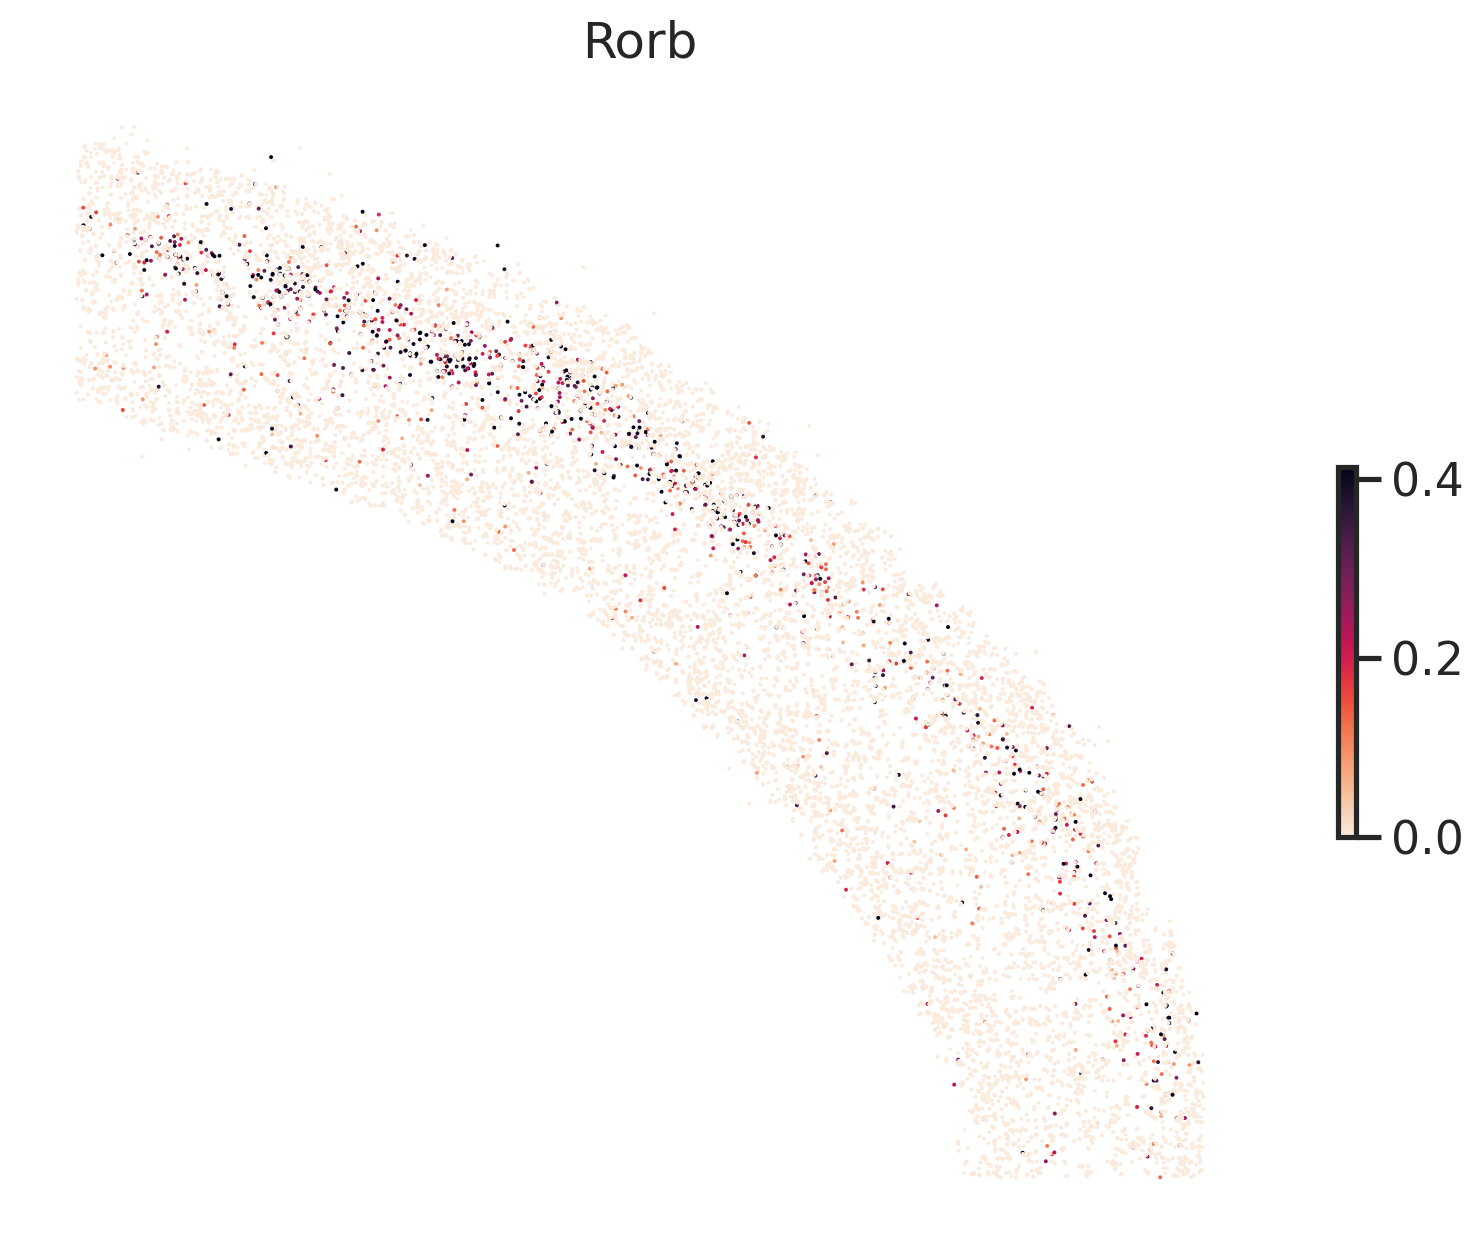

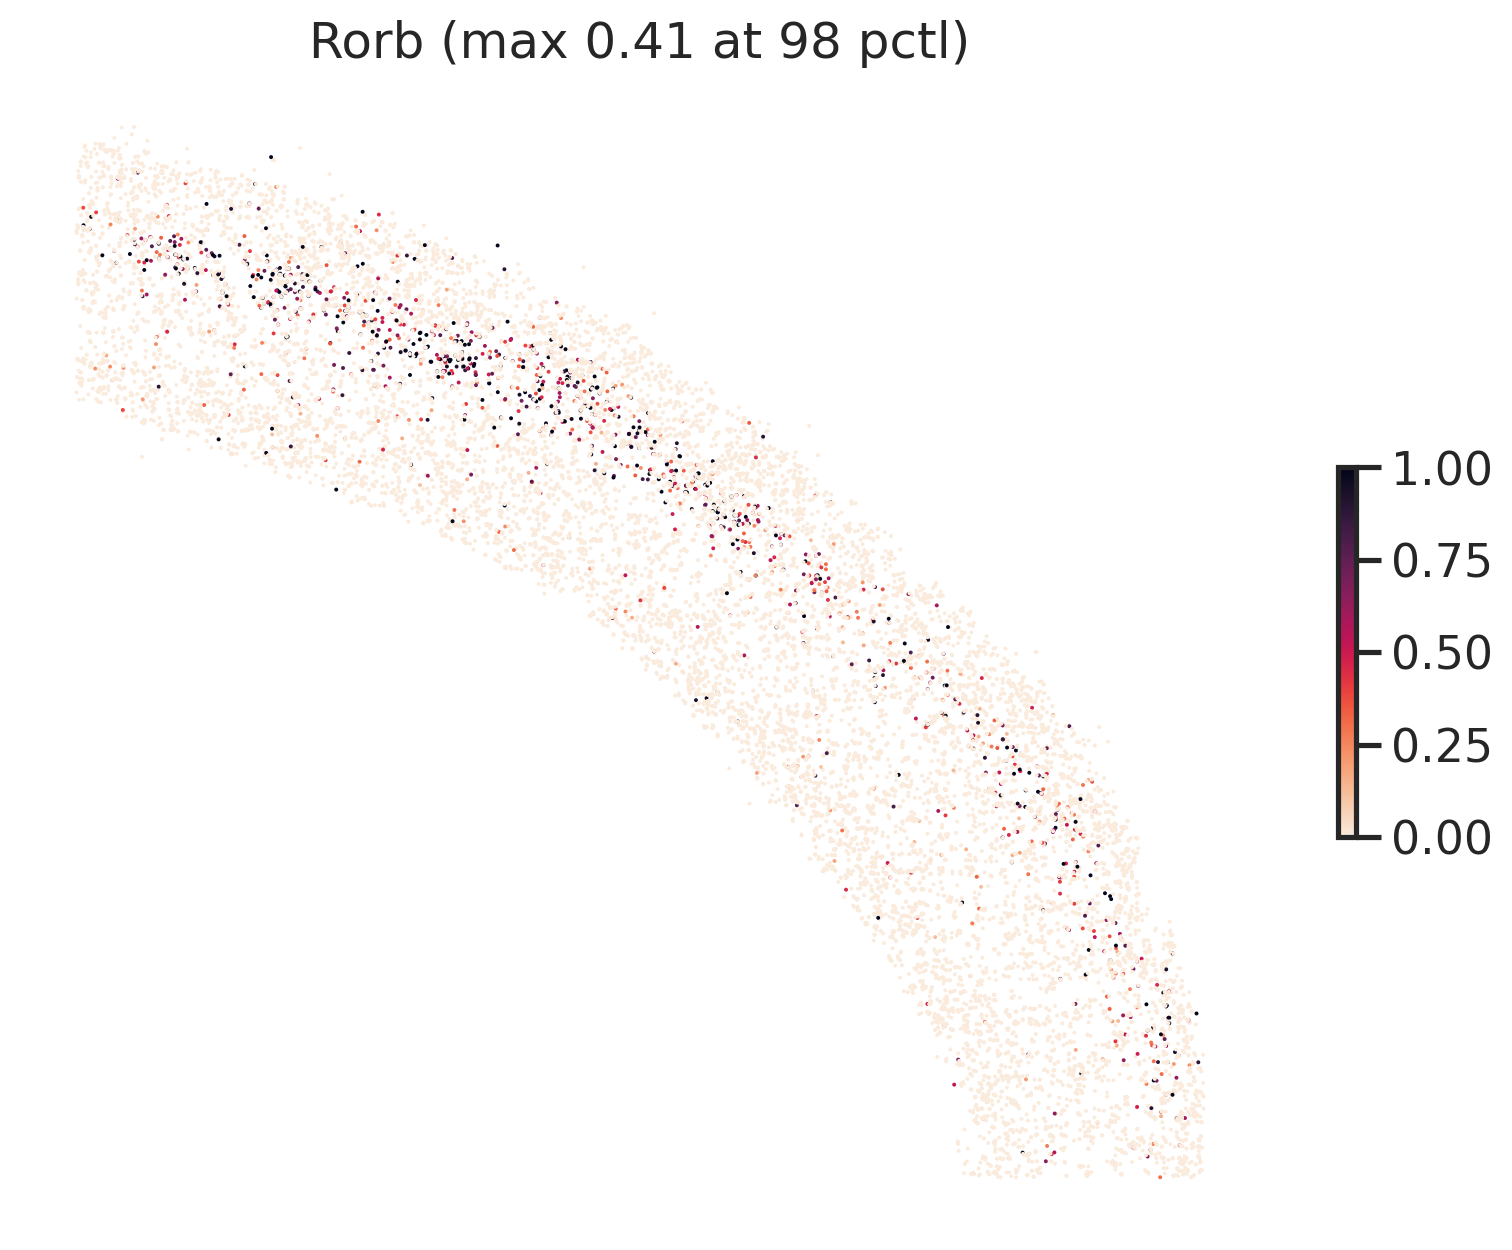

In [6]:
gn = 'Rorb'

x = adata.obs['x']
y = adata.obs['y']
ux = adata.obsm['umap'][:,0]
uy = adata.obsm['umap'][:,1]

g = np.log10(1+adata[:,gn].layers['norm'])

st_scatter(x, y, gexp=g, s=2, title=gn)
st_scatter(x, y, gexp=g, s=2, title=gn, unit_norm=True)
# st_scatter(ux, uy, gexp=g, s=2, title=gn)

In [7]:
# copy my code 
from scipy import spatial

In [8]:

# def p_to_curve(query_point, pia_curve):
#     """return the distance from a point to a set curve
#     measure distance to each segment and take the min
#     """
#     tan_vec = pia_curve[1:] - pia_curve[:-1]
#     # unit
#     tan_vec = tan_vec/np.linalg.norm(tan_vec, axis=1).reshape(-1,1)
#     norm_vec = tan_vec.dot(np.array([[0,-1],[1,0]]).T)
#     # np.power(tan_vec[:,0],2)+np.power(tan_vec[:,1],2) # check normed

#     query_vec = (query_point - pia_curve[:-1])
#     d = np.min(np.abs(query_vec[:,0]*norm_vec[:,0] + query_vec[:,1]*norm_vec[:,1]))
#     return d

# def ps_to_curve(query_points, pia_curve):
#     """return the distance from a set of points to a set curve
#     """
#     tan_vec = pia_curve[1:] - pia_curve[:-1]
#     # unit
#     tan_vec = tan_vec/np.linalg.norm(tan_vec, axis=1).reshape(-1,1)
#     norm_vec = tan_vec.dot(np.array([[0,-1],[1,0]]).T)
    
#     query_mtx = np.repeat(XY[:,np.newaxis,:], len(pia_curve)-1, axis=1) - pia_curve[:-1]
#     ds = np.min(np.abs(query_mtx[:,:,0]*norm_vec[:,0] + query_mtx[:,:,1]*norm_vec[:,1]), axis=1)
#     return ds


In [9]:
# class RefLineSegs:
#     """
#     """
#     def __init__(self, ps):
#         """
#         line segments defined by ps
#         """
#         self.ps = ps
#         self.rps = ps[:-1] # reference points (exclude the last point)
#         self.ns = len(ps)-1 # number of segments
#         # get ts and uts
#         self.calc_tan_vec()
        
#         return
    
#     def calc_tan_vec(self):
#         """get tangent vectors
#         """
#         ps = self.ps 
#         ts = ps[1:] - ps[:-1]
#         lts = np.linalg.norm(ts, axis=1)
#         uts = ts/lts.reshape(-1,1)
#         nuts = uts.dot(np.array([[0,-1],[1,0]]).T)
        
#         # np.power(uts[:,0],2)+np.power(uts[:,1],2) # check normed
        
#         self.ts = ts # tangents
#         self.uts = uts # unitary tangents
#         self.nuts = nuts # norm to unitary tangents
        
#         self.lts = lts # tangent lengths
#         self.cumlts = np.hstack([0,np.cumsum(lts)])[:-1] # cumulative tangent lengths
        
#         return 
    
#     def calc_seg_len(self):
#         """get the length of each segment
#         """
#         ts = self.ts
        
#         np.linalg.norm(ts, axis=1)
        
    
    
#     def ndist_to_qp(self, query_point):
#         """return the distance from a point to a set curve
#         measure distance to each segment and take the min
#         """
#         query_vec = (query_point - self.rps)
#         ndist = np.min(np.abs(query_vec[:,0]*self.nuts[:,0] + query_vec[:,1]*self.nuts[:,1]))
        
#         return ndist
        
#     def ndist_to_qps(self, XY):
#         """return the distance from a point to a set curve
#         measure distance to each segment and take the min
#         """
#         query_mtx = np.repeat(XY[:,np.newaxis,:], self.ns, axis=1) - self.rps
#         tmp = np.abs(query_mtx[:,:,0]*self.nuts[:,0] + query_mtx[:,:,1]*self.nuts[:,1])
#         ndists = np.min(tmp, axis=1)
        
#         return ndists
        
#     def tdist_to_qps(self, XY):
#         """return the distance from a point to a set curve
#         adds up the distance of each segment
#         """
        
#         query_mtx = np.repeat(XY[:,np.newaxis,:], self.ns, axis=1) - self.rps
#         tmp = np.abs(query_mtx[:,:,0]*self.nuts[:,0] + query_mtx[:,:,1]*self.nuts[:,1])
        
#         # which segment
#         min_seg_idx = np.argmin(tmp, axis=1)
        
#         # cumsum up to the segment
#         tdists = self.cumlts[min_seg_idx]
        
        
#         uts = self.uts[min_seg_idx] # tangent vector for each ref point
#         qs_vec = XY - self.rps[min_seg_idx] # 
#         tdists_correction = qs_vec[:,0]*uts[:,0] + qs_vec[:,1]*uts[:,1]
        
#         return tdists+tdists_correction
        


In [10]:
# def binning(val, n):
#     """
#     """
#     bins = np.linspace(np.min(val), np.max(val), n)
#     binned = pd.cut(val, bins=bins)
    
#     return bins, binned

In [11]:
meta = adata.obs.copy()

XY = meta[['x', 'y']].values

# convex hull
hull = spatial.ConvexHull(XY)
pia_vtx = np.hstack([hull.vertices[4:9], hull.vertices[10:17]])[::-1] # reverse order
pia_curve = XY[pia_vtx]
pia_curve_obj = utils_merfish.RefLineSegs(pia_curve)

# depth
meta['depth'] = pia_curve_obj.ndist_to_qps(XY)
meta['width'] = pia_curve_obj.tdist_to_qps(XY)

In [12]:
# bin it 

depth_bins, depth_binned = utils_merfish.binning(meta['depth'].values, 20)
meta['depth_bin'] = depth_binned

width_bins, width_binned = utils_merfish.binning(meta['width'].values, 20)
meta['width_bin'] = width_binned


Text(0.5, 1.0, 'P28 anterior')

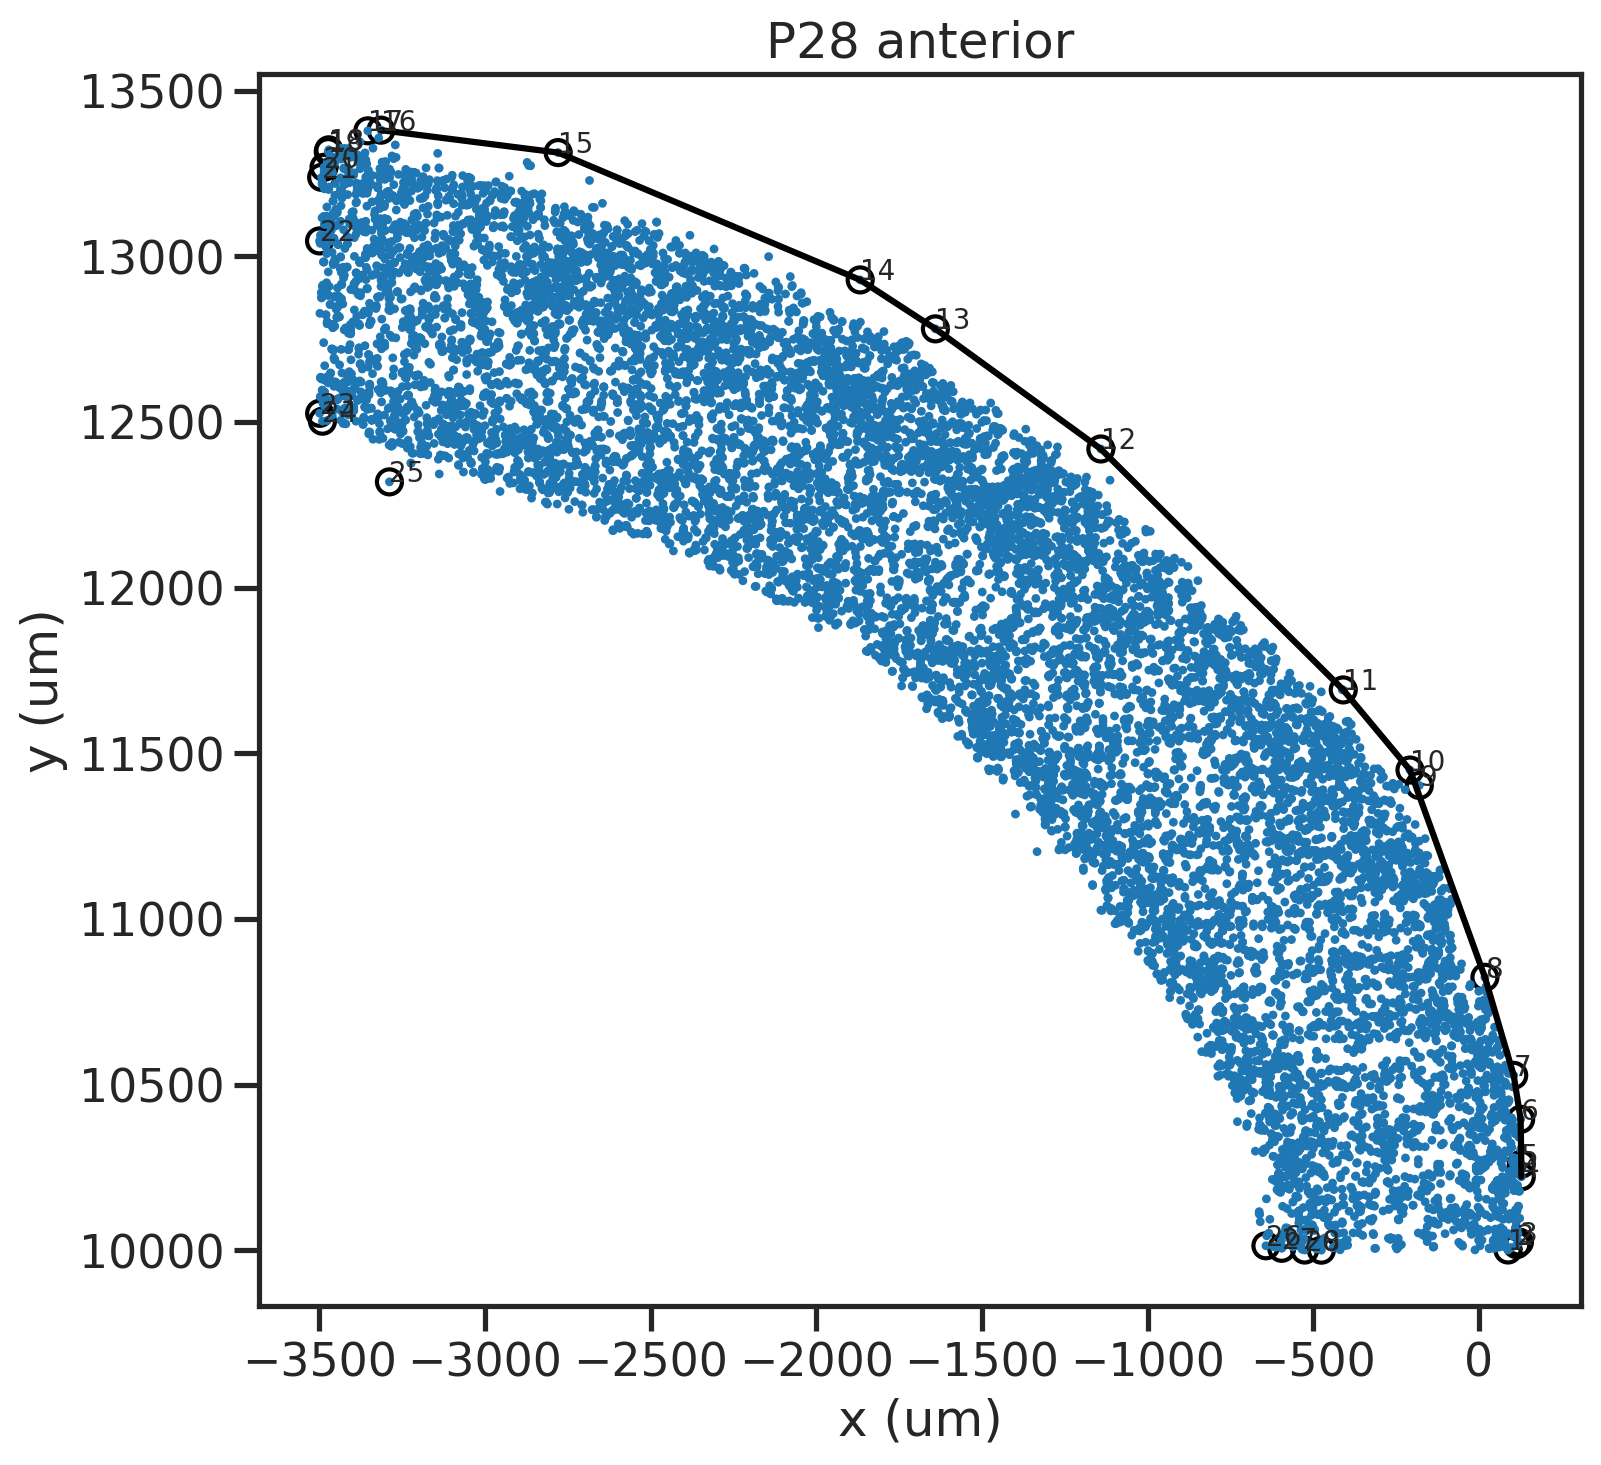

In [13]:
fig, ax = plt.subplots(figsize=(12,8))
for i, vtx in enumerate(hull.vertices):
    ax.scatter(XY[vtx, 0], XY[vtx, 1], facecolors='none', edgecolors='k')
    ax.text(XY[vtx, 0], XY[vtx, 1], i, fontsize=10)
    
for i in range(len(pia_curve)-1):
    ax.plot(pia_curve[i:i+2, 0], 
            pia_curve[i:i+2, 1], 
            '-k')
    
sns.scatterplot(data=meta, x='x', y='y', 
                s=10, edgecolor='none', ax=ax)
ax.grid(False)
ax.set_aspect('equal')
ax.set_xlabel('x (um)')
ax.set_ylabel('y (um)')
ax.set_title(f'P28 anterior')

Text(0.5, 1.0, 'width')

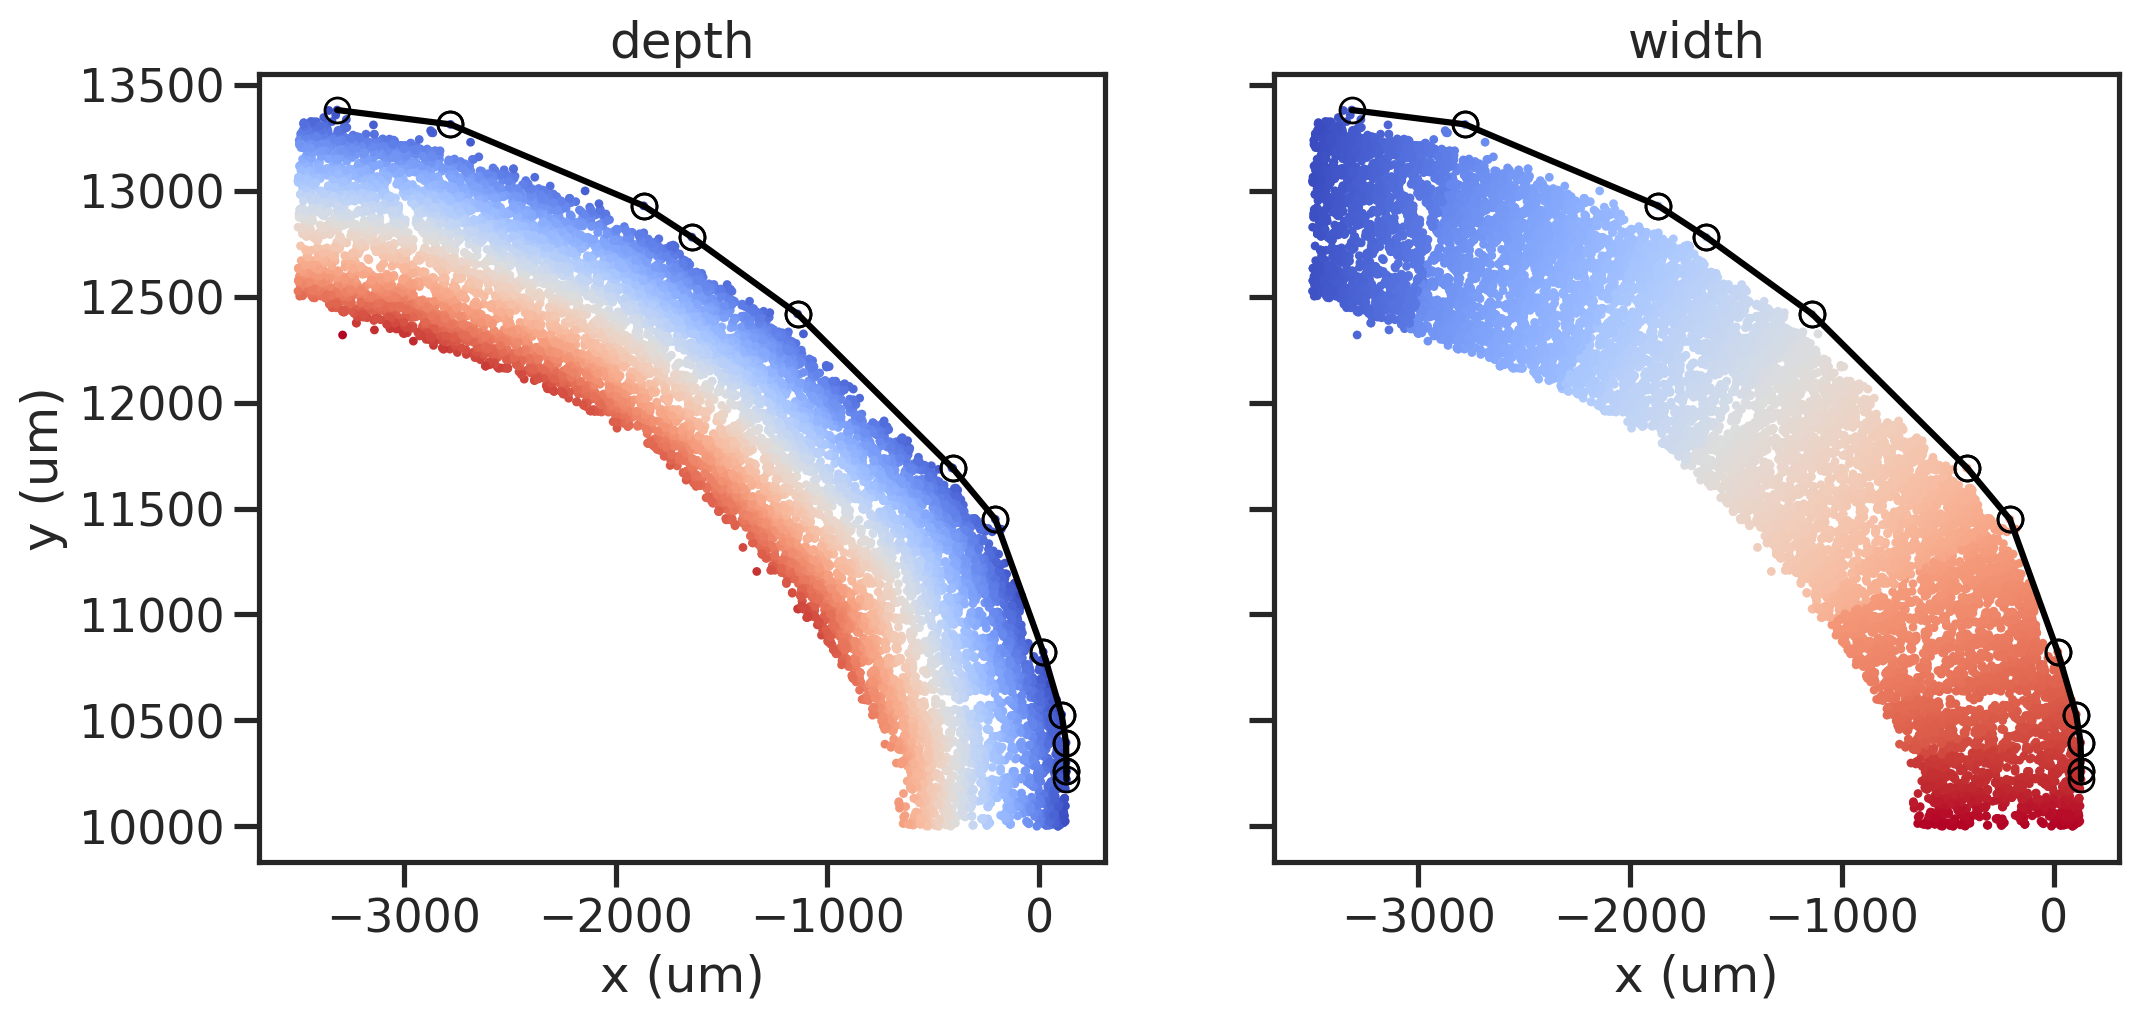

In [14]:
fig, axs = plt.subplots(1,2,figsize=(12,8*2), sharex=True, sharey=True)
ax = axs[0]
    
for i in range(len(pia_curve)-1):
    ax.plot(pia_curve[i:i+2, 0], 
            pia_curve[i:i+2, 1], 
            '-ok', fillstyle='none')
    
sns.scatterplot(data=meta, x='x', y='y', 
                hue='depth', 
                palette='coolwarm',
                legend=False,
                s=10, edgecolor='none', ax=ax)
ax.grid(False)
ax.set_aspect('equal')
ax.set_xlabel('x (um)')
ax.set_ylabel('y (um)')
ax.set_title(f'depth')

ax = axs[1]
for i in range(len(pia_curve)-1):
    ax.plot(pia_curve[i:i+2, 0], 
            pia_curve[i:i+2, 1], 
            '-ok', fillstyle='none')
    
sns.scatterplot(data=meta, x='x', y='y', 
                hue='width', 
                palette='coolwarm',
                legend=False,
                s=10, edgecolor='none', ax=ax)
ax.grid(False)
ax.set_aspect('equal')
ax.set_xlabel('x (um)')
ax.set_ylabel('y (um)')
ax.set_title(f'width')

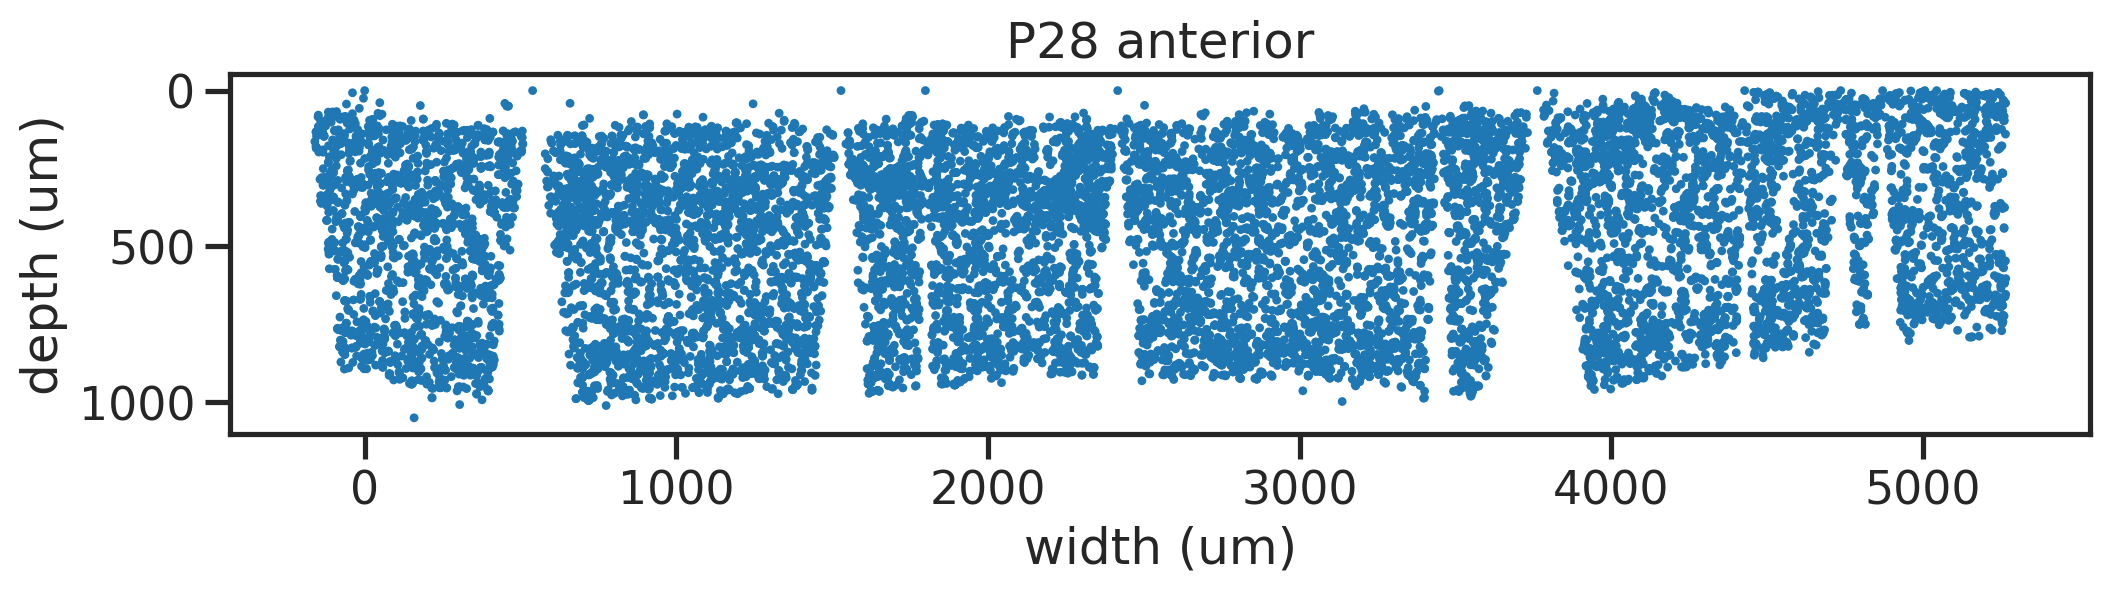

In [15]:
fig, ax = plt.subplots(1,1,figsize=(12,4*1))
sns.scatterplot(data=meta, x='width', y='depth', 
                # hue='width', 
                # palette='coolwarm',
                s=10, edgecolor='none', ax=ax)
ax.grid(False)
ax.set_aspect('equal')
ax.set_xlabel('width (um)')
ax.set_ylabel('depth (um)')
ax.set_title(f'P28 anterior')
ax.invert_yaxis()
# ax.legend(bbox_to_anchor=(1,1))

In [16]:
adata.obs

,x,y,gncov,fpcov,EntityID,fov,volume,center_x,center_y,min_x,...,perimeter_area_ratio,solidity,DAPI_raw,DAPI_high_pass,PolyT_raw,PolyT_high_pass,leiden_r0.1,leiden_r0.2,leiden_spatial_r0.02,leiden_r0.5
843,97.044473,10007.599697,26,0,2596588900021100015,1267,45.469704,10007.599697,-97.044473,10003.841445,...,0.736657,0.935629,4449258.0,4.831360e+04,7859579.0,8.110308e+04,0,0,1,0
848,87.957751,10000.653732,86,1,2596588900021100021,1267,215.311913,10000.653732,-87.957751,9995.148721,...,0.554163,2.303133,34628751.0,5.046920e+05,42422887.0,4.684949e+05,0,0,1,0
850,78.119639,10022.756877,175,4,2596588900021100025,1267,492.809448,10022.756877,-78.119639,10013.507671,...,0.402461,2.406397,92067396.0,1.023039e+06,107969757.0,8.837920e+05,0,0,1,0
853,69.267254,10029.490899,229,4,2596588900021100028,1267,366.973873,10029.490899,-69.267254,10020.852216,...,0.534650,1.854639,56007227.0,6.375997e+05,76568655.0,6.957474e+05,0,0,1,0
860,58.043168,10021.290888,53,0,2596588900021100038,1267,86.109001,10021.290888,-58.043168,10014.393365,...,0.675172,0.797455,16948504.0,2.270514e+05,23843148.0,8.245989e+05,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167985,-3496.226935,12575.284952,13,0,2596588901497100202,873,71.686616,12575.284952,3496.226935,12569.099783,...,0.605532,0.900902,9831271.0,2.138334e+05,14822900.0,1.746902e+05,0,0,2,4
168241,-3493.042294,12873.920150,34,0,2596588901499100113,874,120.436096,12873.920150,3493.042294,12867.373251,...,0.526818,0.819633,13823008.0,1.558116e+05,28098987.0,2.261474e+05,0,2,0,3
168419,-3496.905813,13038.597924,73,1,2596588901501100005,875,338.605722,13038.597924,3496.905813,13034.424943,...,0.713989,4.688497,20487944.0,4.234525e+05,43053015.0,5.807696e+05,0,0,0,1
168420,-3498.870636,13046.008989,157,1,2596588901501100006,875,740.740301,13046.008989,3498.870636,13040.592689,...,0.534803,3.874237,49323439.0,7.936283e+05,97919855.0,1.097442e+06,0,0,0,1


In [17]:
adata.obs['depth'] = meta['depth']
adata.obs['width'] = meta['width']

/tmp/ipykernel_30604/2461476148.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['depth'] = meta['depth']


In [18]:
adata.write('/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results_merfish/pos_reg0_ctxglut_230927.h5ad')